# gw-thal 2:3 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import gwt
import thal2 as t2
import gw2 as g2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d, get_initial_phase_diff_c, get_period, get_phase_lock_full)

from lib.rhs import _redu_c, _full, _redu_full
from lib.rhs import _redu_3dc_thal as _redu_3dc
from lib.rhs import _redu_4dc_thal as _redu_4dc

from lib.plot_util import add_diagram_1d_scatter
from lib.plot_util import quick_plot_combined

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd_thal = {'gL':0.05,'gna':3,'gk':5,
           'gt':5,'eL':-70,'ena':50,
           'ek':-90,'et':0,'esyn':-90,
           'c':1,'alpha':3,'beta':2,
           'sigmat':0.8,'vt':-20,
           'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
pd_gw = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
         'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
         'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
         'n':6,'L':0,'del':0,'om':1,'om_fix':1}

In [5]:
# default period must be 2*np.pi
kw_thal = {'var_names':['v','h','r','w'],
        'pardict':pd_thal,
        'rhs':t2.rhs,
        'coupling':gwt.coupling_thal,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':.5}

In [6]:
kw_gw = {'var_names':['x','y','z','v'],
        'pardict':pd_gw,
        'rhs':g2.rhs,
        'coupling':gwt.coupling_gw,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':20000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':.5}

## Defs

In [7]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [8]:
etup21 = (.001,.15,200)
eps_list21r = np.linspace(*etup21)

In [9]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [10]:
bifdir3d = 'bifgwt_r3d/'

## Initialize Response Functions

In [11]:
system1 = rsp(idx=0,model_name='gwt0',**kw_thal)
system2 = rsp(idx=1,model_name='gwt1',**kw_gw)

mkdir ./data/gwt0/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981522495121
* Loading monodromy...
* Floquet Exponent kappa =-0.02435447459610879
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/gwt1/
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975601737
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


In [12]:
recompute_list = ['h_data_gwt0','h_data_gwt1','p_data_gwt0','p_data_gwt1']
# recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',3),
        'NH':2048,'save_fig':False,'recompute_list':recompute_list}

# del=0.0

In [13]:
del23_p0 = 0
a23_p0 = nm.nmCoupling(**kw_nm, del1=del23_p0)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [14]:
kw_follow = {'a':a23_p0,'del1':del23_p0,'recompute':False,
             'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [15]:
data_list = []

In [16]:
in_dicts = [dict(init=0,eps_init=0.1,eps_final=0.005,deps=-.005),
            dict(init=0,eps_init=0.1,eps_final=0.16,deps=.01)]

In [17]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_23_p0.txt'

fname1 td_branch_init=0_nm=23_del=0_ei=0.1_ef=0.005_de=-0.005.txt
fname2 ts_branch_init=0_nm=23_del=0_ei=0.1_ef=0.005_de=-0.005.txt
fname1 td_branch_init=0_nm=23_del=0_ei=0.1_ef=0.16_de=0.01.txt
fname2 ts_branch_init=0_nm=23_del=0_ei=0.1_ef=0.16_de=0.01.txt


In [18]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [19]:
kw_follow_r3d = {'a':a23_p0,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [20]:
data_list_r3d = []

In [21]:
in_dicts_r3d = [dict(init=1,eps_tup=(.05,.16,.01)),
                dict(init=1,eps_tup=(.05,.001,-.001)),
                dict(init=3,eps_tup=(.05,.16,.01)),
                dict(init=3,eps_tup=(.05,.001,-.001)),
                dict(init=5,eps_tup=(.05,.16,.01)),
                dict(init=5,eps_tup=(.05,.001,-.001))]

In [22]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_23_p0.txt'

eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [23]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot Bifurcations

eps_min 0.01499999999999993


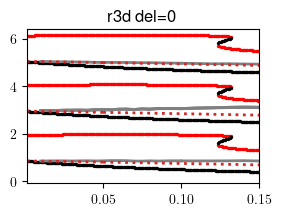

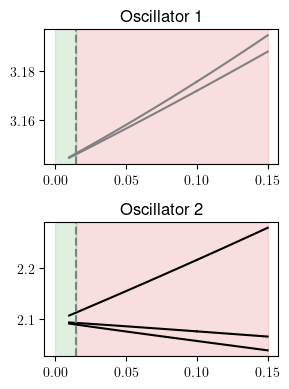

In [24]:
quick_plot_combined(a23_p0,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup21})

## Sims

In [25]:
# coupling and init
eps23_p0 = 0.1
th_init23_p0 = 2

In [26]:
# sim params
dt = .01;T_p0=200
t23_p0 = np.arange(0,T_p0,dt)
args23_p0 = {'args':(a23_p0,eps23_p0,del23_p0),
             't_eval':t23_p0,**kw_sim,'dense_output':True}

In [27]:
# initialize and run full
y0a = a23_p0.system1.lc['dat'][int((th_init23_p0/(2*np.pi)) * a23_p0.system1.TN),:]
y0b = a23_p0.system2.lc['dat'][int((0/(2*np.pi)) * a23_p0.system2.TN),:]

y0_p0 = np.array([y0a,y0b]).flatten()

solf23_p0 = solve_ivp(_full,[0,t23_p0[-1]],
                        y0_p0, **args23_p0)

In [28]:
solr23_p0 = solve_ivp(_redu_c,[0,t23_p0[-1]],
                     [th_init23_p0],**args23_p0)

In [29]:
# solr12b_p0 = solve_ivp(_redu_3dc,[0,t23_p0[-1]],
#                     [th_init23_p0,0,0],**args23_p0)

In [30]:
tp12a_p0, phase12a_p0 = get_phase(t23_p0,solf23_p0.y.T[:,:4],
                            skipn=50,system1=a23_p0.system1)
tp12b_p0, phase12b_p0 = get_phase(t23_p0,solf23_p0.y.T[:,4:],
                            skipn=50,system1=a23_p0.system2)

(-0.5, 6.783185307179586)

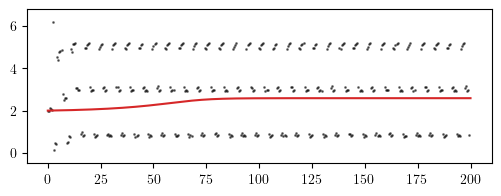

In [31]:
fig,axs = plt.subplots(figsize=(6,2))
y = np.mod(phase12a_p0 - a23_p0.om*phase12b_p0,2*np.pi)
axs.scatter(tp12a_p0,y,s=1,alpha=.5,color='black')

axs.plot(t23_p0,np.mod(solr23_p0.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.01

In [32]:
del23_p01 = .01
a23_p01 = nm.nmCoupling(**kw_nm, del1=del23_p01)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [33]:
kw_follow = {'a':a23_p01,'del1':del23_p01,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [34]:
data_list = []

In [35]:
in_dicts = [dict(init=1,eps_init=0.1,eps_final=0.005,deps=-.005),
            dict(init=1,eps_init=0.1,eps_final=0.16,deps=.01)]

In [36]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_23_p01.txt'

fname1 td_branch_init=1_nm=23_del=0.01_ei=0.1_ef=0.005_de=-0.005.txt
fname2 ts_branch_init=1_nm=23_del=0.01_ei=0.1_ef=0.005_de=-0.005.txt
fname1 td_branch_init=1_nm=23_del=0.01_ei=0.1_ef=0.16_de=0.01.txt
fname2 ts_branch_init=1_nm=23_del=0.01_ei=0.1_ef=0.16_de=0.01.txt


In [37]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [38]:
kw_follow_r3d = {'a':a23_p01,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [39]:
data_list_r3d = []

In [40]:
in_dicts_r3d = [dict(init=1,eps_tup=(.05,.16,.01)),
                dict(init=1,eps_tup=(.05,.001,-.001)),
                dict(init=3,eps_tup=(.05,.16,.01)),
                dict(init=3,eps_tup=(.05,.001,-.001)),
                dict(init=5,eps_tup=(.05,.16,.01)),
                dict(init=5,eps_tup=(.05,.001,-.001))]

In [41]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_23_p01.txt'

eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [42]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot Bifurcations

eps_min 0.01499999999999993


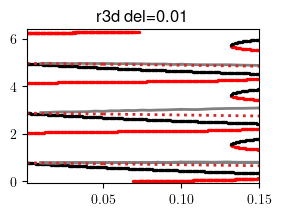

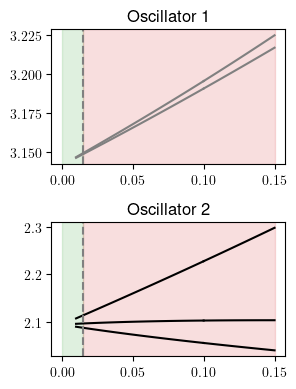

In [43]:
quick_plot_combined(a23_p01,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup21})

## Sims

In [44]:
# coupling and init
eps23_p01 = 0.1
th_init23_p01 = 0

In [45]:
# sim params
dt = .01;T_p01=300
t23_p01 = np.arange(0,T_p01,dt)
args23_p01 = {'args':(a23_p01,eps23_p01,del23_p01),
             't_eval':t23_p01,**kw_sim,'dense_output':True}

In [46]:
# initialize and run full
y0a = a23_p01.system1.lc['dat'][int((th_init23_p01/(2*np.pi)) * a23_p01.system1.TN),:]
y0b = a23_p01.system2.lc['dat'][int((0/(2*np.pi)) * a23_p01.system2.TN),:]

y0_p01 = np.array([y0a,y0b]).flatten()

solf23_p01 = solve_ivp(_full,[0,t23_p01[-1]],
                        y0_p01, **args23_p01)

In [47]:
solr23_p01 = solve_ivp(_redu_c,[0,t23_p01[-1]],
                     [th_init23_p01],**args23_p01)

In [48]:
# solr12b_p01 = solve_ivp(_redu_3dc,[0,t23_p01[-1]],
#                     [th_init23_p01,0,0],**args23_p01)

In [49]:
tp12a_p01, phase12a_p01 = get_phase(t23_p01,solf23_p01.y.T[:,:4],
                            skipn=50,system1=a23_p01.system1)
tp12b_p01, phase12b_p01 = get_phase(t23_p01,solf23_p01.y.T[:,4:],
                            skipn=50,system1=a23_p01.system2)

(-0.5, 6.783185307179586)

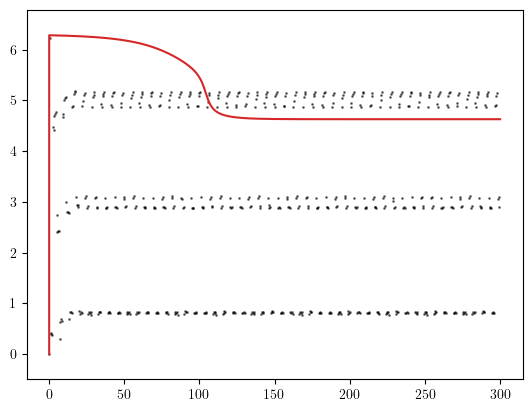

In [50]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p01 - a23_p01.om*phase12b_p01,2*np.pi)
axs.scatter(tp12a_p01,y,s=1,alpha=.5,color='black')

axs.plot(t23_p01,np.mod(solr23_p01.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.02

In [51]:
del23_p02 = .02
a23_p02 = nm.nmCoupling(**kw_nm, del1=del23_p02)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [52]:
kw_follow = {'a':a23_p02,'del1':del23_p02,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [53]:
data_list = []

In [54]:
in_dicts = [dict(init=1,eps_init=0.1,eps_final=0.046,deps=-.005),
            dict(init=1,eps_init=0.055,eps_final=0.001,deps=-.002),
            dict(init=0,eps_init=0.1,eps_final=0.16,deps=.01)]

In [55]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_23_p02.txt'

fname1 td_branch_init=1_nm=23_del=0.02_ei=0.1_ef=0.046_de=-0.005.txt
fname2 ts_branch_init=1_nm=23_del=0.02_ei=0.1_ef=0.046_de=-0.005.txt
fname1 td_branch_init=1_nm=23_del=0.02_ei=0.055_ef=0.001_de=-0.002.txt
fname2 ts_branch_init=1_nm=23_del=0.02_ei=0.055_ef=0.001_de=-0.002.txt
fname1 td_branch_init=0_nm=23_del=0.02_ei=0.1_ef=0.16_de=0.01.txt
fname2 ts_branch_init=0_nm=23_del=0.02_ei=0.1_ef=0.16_de=0.01.txt


In [56]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [57]:
kw_follow_r3d = {'a':a23_p02,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/'}

In [58]:
data_list_r3d = []

In [59]:
in_dicts_r3d = [dict(init=1,eps_tup=(.05,.16,.01)),
                dict(init=1,eps_tup=(.05,.001,-.001)),
                dict(init=3,eps_tup=(.05,.16,.01)),
                dict(init=3,eps_tup=(.05,.001,-.001)),
                dict(init=5,eps_tup=(.05,.16,.01)),
                dict(init=5,eps_tup=(.05,.001,-.001))]

In [60]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_23_p02.txt'

eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)
eps_tup (0.05, 0.16, 0.01)
eps_tup (0.05, 0.001, -0.001)


In [61]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot Bifurcations

eps_min 0.010999999999999961


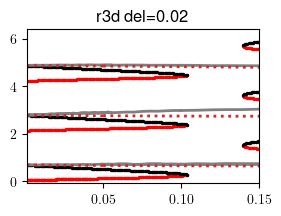

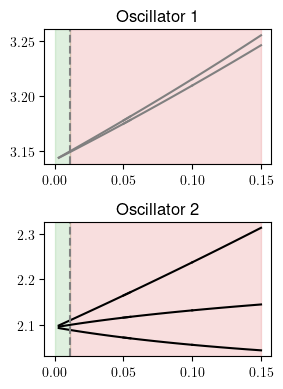

In [62]:
quick_plot_combined(a23_p02,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup21})

## Sims

In [63]:
# coupling and init
eps23_p02 = 0.1
th_init23_p02 = 0

In [64]:
# sim params
dt = .01;T_p02=300
t23_p02 = np.arange(0,T_p02,dt)
args23_p02 = {'args':(a23_p02,eps23_p02,del23_p02),
             't_eval':t23_p02,**kw_sim,'dense_output':True}

In [65]:
# initialize and run full
y0a = a23_p02.system1.lc['dat'][int((th_init23_p02/(2*np.pi)) * a23_p02.system1.TN),:]
y0b = a23_p02.system2.lc['dat'][int((0/(2*np.pi)) * a23_p02.system2.TN),:]

y0_p02 = np.array([y0a,y0b]).flatten()

solf23_p02 = solve_ivp(_full,[0,t23_p02[-1]],
                        y0_p02, **args23_p02)

In [66]:
solr23_p02 = solve_ivp(_redu_c,[0,t23_p02[-1]],
                     [th_init23_p02],**args23_p02)

In [67]:
# solr12b_p02 = solve_ivp(_redu_3dc,[0,t23_p02[-1]],
#                     [th_init23_p02,0,0],**args23_p02)

In [68]:
tp12a_p02, phase12a_p02 = get_phase(t23_p02,solf23_p02.y.T[:,:4],
                            skipn=50,system1=a23_p02.system1)
tp12b_p02, phase12b_p02 = get_phase(t23_p02,solf23_p02.y.T[:,4:],
                            skipn=50,system1=a23_p02.system2)

(-0.5, 6.783185307179586)

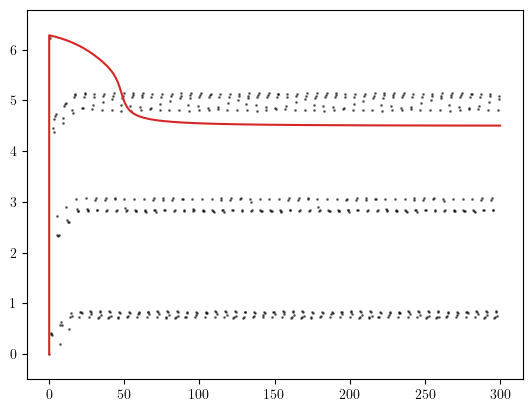

In [69]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p02 - a23_p02.om*phase12b_p02,2*np.pi)
axs.scatter(tp12a_p02,y,s=1,alpha=.5,color='black')

axs.plot(t23_p02,np.mod(solr23_p02.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

# del=0.04

In [70]:
del23_p04 = .04
a23_p04 = nm.nmCoupling(**kw_nm, del1=del23_p04)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [71]:
kw_follow = {'a':a23_p04,'del1':del23_p04,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [72]:
data_list = []

In [73]:
in_dicts = [dict(init=1,eps_init=0.02,eps_final=0.1,deps=.01),
            dict(init=1,eps_init=0.02,eps_final=0.008,deps=-.002)]

In [74]:
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_follow)
    data_list.append(dat)
fname = kw_follow['bifdir']+'hyper_gwt_23_p04.txt'

fname1 td_branch_init=1_nm=23_del=0.04_ei=0.02_ef=0.1_de=0.01.txt
fname2 ts_branch_init=1_nm=23_del=0.04_ei=0.02_ef=0.1_de=0.01.txt
fname1 td_branch_init=1_nm=23_del=0.04_ei=0.02_ef=0.008_de=-0.002.txt
fname2 ts_branch_init=1_nm=23_del=0.04_ei=0.02_ef=0.008_de=-0.002.txt


In [75]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['init']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [76]:
data_list_r3d = []

In [77]:
kw_follow_r3d = {'a':a23_p04,'rhs':_redu_3dc,'recompute':False,
                 'bifdir':'bif1d_gwt/','max_iter':10}

In [78]:
in_dicts_r3d = [dict(init=1,eps_tup=(.05,.06,.005)),
                dict(init=1,eps_tup=(.05,.045,-.005))]

In [79]:
for i in range(len(in_dicts_r3d)):
    in1 = in_dicts_r3d[i]
    dat = follow_locking_3d(**in1,**kw_follow_r3d)
    data_list_r3d.append(dat)
fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_23_p04.txt'

eps_tup (0.05, 0.06, 0.005)
eps_tup (0.05, 0.045, -0.005)


In [80]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts_r3d),4])
for i in range(len(in_dicts_r3d)):
    hyp_inputs[i,0] = in_dicts_r3d[i]['init']
    hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
    hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
    hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
np.savetxt(fname,hyp_inputs)

## Plot Bifurcations

eps_min 0.010000000000000009


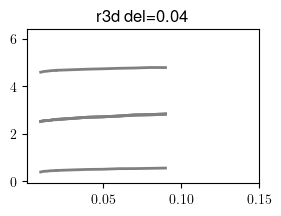

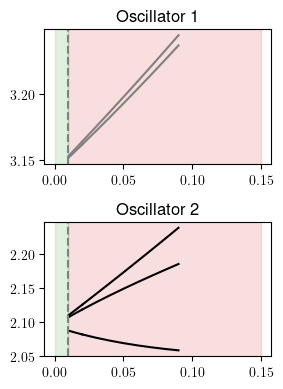

In [81]:
quick_plot_combined(a23_p04,
                    kw_f={'data_list':data_list},
                    kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup21})

## Sims

In [82]:
# coupling and init
eps23_p04 = 0.02
th_init23_p04 = 0

In [83]:
# sim params
dt = .01;T_p04=1000
t23_p04 = np.arange(0,T_p04,dt)
args23_p04 = {'args':(a23_p04,eps23_p04,del23_p04),
             't_eval':t23_p04,**kw_sim,'dense_output':True}

In [84]:
# initialize and run full
y0a = a23_p04.system1.lc['dat'][int((th_init23_p04/(2*np.pi)) * a23_p04.system1.TN),:]
y0b = a23_p04.system2.lc['dat'][int((0/(2*np.pi)) * a23_p04.system2.TN),:]

y0_p04 = np.array([y0a,y0b]).flatten()

solf23_p04 = solve_ivp(_full,[0,t23_p04[-1]],y0_p04, **args23_p04)

In [85]:
solr23_p04 = solve_ivp(_redu_c,[0,t23_p04[-1]],[th_init23_p04],**args23_p04)

In [86]:
# solr12b_p04 = solve_ivp(_redu_3dc,[0,t23_p04[-1]],
#                     [th_init23_p04,0,0],**args23_p04)

In [87]:
tp12a_p04, phase12a_p04 = get_phase(t23_p04,solf23_p04.y.T[:,:4],
                            skipn=50,system1=a23_p04.system1)
tp12b_p04, phase12b_p04 = get_phase(t23_p04,solf23_p04.y.T[:,4:],
                            skipn=50,system1=a23_p04.system2)

(-0.5, 6.783185307179586)

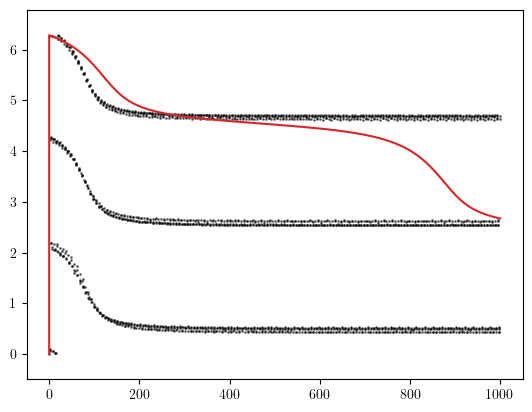

In [88]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p04 - a23_p04.om*phase12b_p04,2*np.pi)
axs.scatter(tp12a_p04,y,s=1,alpha=.5,color='black')

axs.plot(t23_p04,np.mod(solr23_p04.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

(300.0, 400.0)

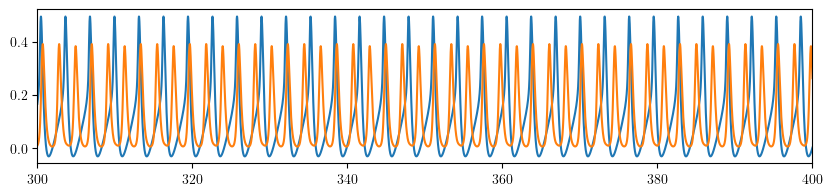

In [89]:
fig,axs = plt.subplots(figsize=(10,2))
axs.plot(solf23_p04.t,solf23_p04.y.T[:,0]+.6)
axs.plot(solf23_p04.t,solf23_p04.y.T[:,4])
axs.set_xlim(300,400)

# del=0.05

In [90]:
del23_p05 = .05
a23_p05 = nm.nmCoupling(**kw_nm, del1=del23_p05)

pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
p order=1
p order=1
p order=2
p order=2
p order=3
p order=3
* Loading H symbolic...
* Loading H symbolic...
* Computing H gwt0, order=0...
* Computing H gwt1, order=0...
* Computing H gwt0, order=1...
* Computing H gwt1, order=1...
* Computing H gwt0, order=2...
* Computing H gwt1, order=2...
* Computing H gwt0, order=3...
* Computing H gwt1, order=3...


## Get Branches Full

In [91]:
kw_follow = {'a':a23_p05,'del1':del23_p05,'recompute':False,
            'bifdir':'bif1d_gwt/','_full_rhs':_full}

In [92]:
data_list = []

In [93]:
# in_dicts = [dict(init=1,eps_init=0.02,eps_final=0.1,deps=.01),
#             dict(init=1,eps_init=0.02,eps_final=0.008,deps=-.002)]

In [94]:
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(**in1,**kw_follow)
#     data_list.append(dat)
# fname = kw_follow['bifdir']+'hyper_gwt_23_p05.txt'

In [95]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['init']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [96]:
# kw_follow_r3d = {'a':a23_p05,'rhs':_redu_3dc,'recompute':False,
#                  'bifdir':'bif1d_gwt/'}

In [97]:
# data_list_r3d = []

In [98]:
# in_dicts_r3d = [dict(init=1,eps_tup=(.05,.16,.01)),
#                 dict(init=1,eps_tup=(.05,.001,-.001))]

In [99]:
# for i in range(len(in_dicts_r3d)):
#     in1 = in_dicts_r3d[i]
#     dat = follow_locking_3d(**in1,**kw_follow_r3d)
#     data_list_r3d.append(dat)
# fname = kw_follow_r3d['bifdir']+'hyper_r3d_gwt_23_p05.txt'

In [100]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts_r3d),4])
# for i in range(len(in_dicts_r3d)):
#     hyp_inputs[i,0] = in_dicts_r3d[i]['init']
#     hyp_inputs[i,1] = in_dicts_r3d[i]['eps_tup'][0]
#     hyp_inputs[i,2] = in_dicts_r3d[i]['eps_tup'][1]
#     hyp_inputs[i,3] = in_dicts_r3d[i]['eps_tup'][2]
# np.savetxt(fname,hyp_inputs)

## Plot Bifurcations

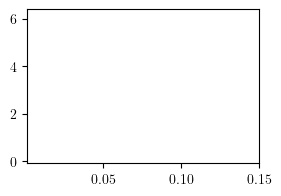

In [101]:
quick_plot_combined(a23_p05,
                    #kw_f={'data_list':data_list},
                    # kw_r3d={'data_list':data_list_r3d},
                    kw_r={'etup':etup21})

## Sims

In [102]:
# coupling and init
eps23_p05 = 0.05
th_init23_p05 = 0

In [103]:
# sim params
dt = .01;T_p05=1000
t23_p05 = np.arange(0,T_p05,dt)
args23_p05 = {'args':(a23_p05,eps23_p05,del23_p05),
             't_eval':t23_p05,**kw_sim,'dense_output':True}

In [104]:
# initialize and run full
y0a = a23_p05.system1.lc['dat'][int((th_init23_p05/(2*np.pi)) * a23_p05.system1.TN),:]
y0b = a23_p05.system2.lc['dat'][int((0/(2*np.pi)) * a23_p05.system2.TN),:]

y0_p05 = np.array([y0a,y0b]).flatten()

solf23_p05 = solve_ivp(_full,[0,t23_p05[-1]],y0_p05, **args23_p05)

In [105]:
solr23_p05 = solve_ivp(_redu_c,[0,t23_p05[-1]],[th_init23_p05],**args23_p05)

In [106]:
# solr12b_p05 = solve_ivp(_redu_3dc,[0,t23_p05[-1]],
#                     [th_init23_p05,0,0],**args23_p05)

In [107]:
tp12a_p05, phase12a_p05 = get_phase(t23_p05,solf23_p05.y.T[:,:4],
                            skipn=50,system1=a23_p05.system1)
tp12b_p05, phase12b_p05 = get_phase(t23_p05,solf23_p05.y.T[:,4:],
                            skipn=50,system1=a23_p05.system2)

(-0.5, 6.783185307179586)

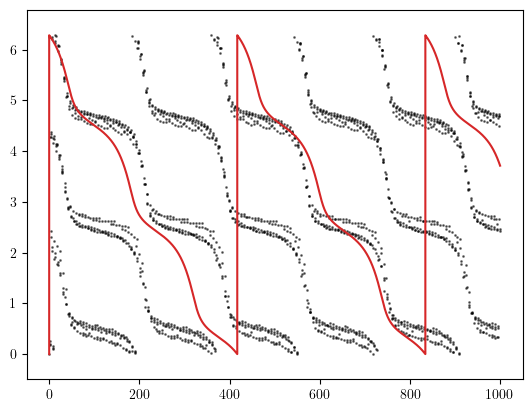

In [108]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p05 - a23_p05.om*phase12b_p05,2*np.pi)
axs.scatter(tp12a_p05,y,s=1,alpha=.5,color='black')

axs.plot(t23_p05,np.mod(solr23_p05.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)

(300.0, 400.0)

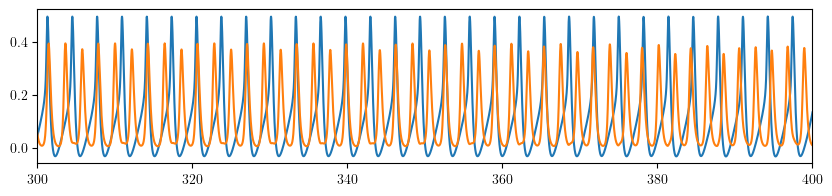

In [109]:
fig,axs = plt.subplots(figsize=(10,2))
axs.plot(solf23_p05.t,solf23_p05.y.T[:,0]+.6)
axs.plot(solf23_p05.t,solf23_p05.y.T[:,4])
axs.set_xlim(300,400)